# Support Vector Classifiers

# Workspace Setup

In [0]:
# Common imports
import numpy as np 
import pandas as pd 

# Seed random number generator for reproducability across runs
np.random.seed(42)

# For file manipulation
import os

# Plotting imports
import matplotlib.pyplot as plt 
from matplotlib import style
style.use('ggplot')
%matplotlib inline 

# Seaborn for generating distribution plots
from seaborn import distplot 

# Scikit-Learn imports - data splitting
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate

# Scikit-Learn imports - preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Scikit-Learn Support Vector Imports
from sklearn.svm import SVC

# Scikit-Learn imports - Classification resutlts
from sklearn.metrics import classification_report, plot_confusion_matrix, plot_roc_curve, roc_auc_score

# For timing
import time

# Functions

## Function 1 - Classification Result

In [0]:
def get_classification_result(estimator, X, y_true, classifier_name=None, 
                              normalize_conf_mat='all'):
  # Get the predicted classes for this classifier
  y_pred = estimator.predict(X)

  # Display the classification report
  print("CLASSIFICATION REPORT")
  print(classification_report(y_true, y_pred, labels=[0, 1], 
                              target_names=['Regular Consumer', 'Thief']))
  
  # Confusion Matrix processing 
  if (normalize_conf_mat=='rows'):
    normalize = 'true'
  elif normalize_conf_mat=='cols':
    normalize = 'pred'
  else:
    normalize = normalize_conf_mat

  # Use built-in function to get confusion matrix
  conf_mat_display = plot_confusion_matrix(estimator, 
                                           X, y_true, 
                                           labels=[0, 1], 
                                           normalize=normalize,
                                           display_labels=['Regular Consumers', 'Thieves'], 
                                           cmap='Blues')
  
  # Render the confusion matrix
  print(conf_mat_display.confusion_matrix)

  # Do not render the grid lines in the confusion matrix
  plt.grid(False)

  # Add a title to the confusion matrix
  conf_mat_display.ax_.set_title('Confusion Matrix' + 
                                 ('' if classifier_name is None else ' - {}'.format(classifier_name)), 
                                 fontsize=18)
  
  # Display ROC curve
  roc_curve_display = plot_roc_curve(estimator, X, y_true)
  roc_curve_display.ax_.set_title('ROC Curve' + ('' if classifier_name is None 
                                     else ' - {}'.format(classifier_name)), 
               fontsize=18);


# Loading Data

## Mounting Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Defining Filepaths

In [0]:
# Subdirectory paths to make up final filepath
ROOT_DIR = '/content/drive'
DRIVE = 'My Drive'
FYP = "EE 16-17 FYP DL Energy Theft Detection"
DATA = "Data"
PROCESSED_DATA = 'full-processing-data'
DATA_DIR_PATH = os.path.join(ROOT_DIR, DRIVE, FYP, DATA, PROCESSED_DATA)

# Filenames for minmax scaled and unscaled data 
RAW_DATA_FILE = 'outliersRemoved.csv'

In [0]:
# Making filepaths
raw_data_filepath = os.path.join(DATA_DIR_PATH, RAW_DATA_FILE)

## Reading Data

In [0]:
# Raw data to be transformed into minmax
raw_data = pd.read_csv(raw_data_filepath)

In [7]:
# Did it work
raw_data.head()

,CONS_NO,FLAG,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,2014-01-09,2014-01-10,2014-01-11,2014-01-12,2014-01-13,2014-01-14,2014-01-15,2014-01-16,2014-01-17,2014-01-18,2014-01-19,2014-01-20,2014-01-21,2014-01-22,2014-01-23,2014-01-24,2014-01-25,2014-01-26,2014-01-27,2014-01-28,2014-01-29,2014-01-30,2014-01-31,2014-02-01,2014-02-02,2014-02-03,2014-02-04,2014-02-05,2014-02-06,2014-02-07,...,2016-09-22,2016-09-23,2016-09-24,2016-09-25,2016-09-26,2016-09-27,2016-09-28,2016-09-29,2016-09-30,2016-10-01,2016-10-02,2016-10-03,2016-10-04,2016-10-05,2016-10-06,2016-10-07,2016-10-08,2016-10-09,2016-10-10,2016-10-11,2016-10-12,2016-10-13,2016-10-14,2016-10-15,2016-10-16,2016-10-17,2016-10-18,2016-10-19,2016-10-20,2016-10-21,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,0387DD8A07E07FDA6271170F86AD9151,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,...,8.56,10.48,8.20,12.53,7.90,8.58,10.12,9.96,7.60,18.19,10.93,11.41,19.92,10.70,9.20,6.77,6.760000,6.150000,6.500000,8.080000,7.97,8.810000,7.370000,11.720000,11.020000,8.180000,7.330000,6.710000,8.520000,6.310000,7.18,8.070000,8.090000,9.530000,5.480000,8.750000,9.300000,7.540000,9.160000,6.740000
1,01D6177B5D4FFE0CABA9EF17DAFC2B84,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,4B75AC4F2D8434CFF62DB64D0BB43103,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,8.34,13.483126,13.483126,13.483126,13.483126,12.73,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,10.95,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126
3,B32AC8CC6D5D805AC053557AB05F5343,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,...,17.30,16.95,8.25,22.76,14.07,20.70,6.50,9.99,18.59,16.79,26.82,14.70,16.05,24.10,12.64,10.85,11.770000,13.030000,12.260000,15.660000,13.43,15.030000,14.610000,13.970000,15.070000,14.110000,14.770000,11.720000,11.730000,11.980000,12.81,15.120000,17.260000,14.910000,19.590000,20.790000,17.950000,19.260000,14.460000,11.720000
4,EDFC78B07BA2908B3395C4EB2304665E,1,2.9,5.64,6.99,3.32,3.61,5.35,4.73,3.68,3.53,3.42,3.81,4.58,3.56,4.25,3.86,3.53,3.41,0.85,0.88,3.81,6.51,9.19,7.79,7.02,7.25,6.37,6.43,7.89,7.46,7.95,7.59,4.84,6.06,5.6,6.72,7.29,5.6,6.28,...,9.56,9.48,10.60,10.06,10.79,10.91,17.77,10.37,13.51,14.13,17.44,15.96,12.18,18.54,13.44,11.68,9.150000,9.160000,10.190000,10.310000,8.03,10.080000,10.340000,11.240000,15.140000,14.360000,12.390000,10.360000,9.290000,7.910000,14.21,10.220000,8.470000,6.110000,6.100000,6.730000,7.520000,10.890000,9.860000,8.720000


## Extracting Features and Labels

In [0]:
X = raw_data.iloc[:, 2:]
y = raw_data.iloc[:, 1]

# Scaling Data

## `MinMax` Scaling

In [0]:
# Instantiate a `MinMaxScaler` 
minMaxScaler = MinMaxScaler()

In [0]:
# Fit to each consumer using transpositions 
X_minmax = minMaxScaler.fit_transform(X.transpose()).transpose()

In [11]:
# Confirm shape
X_minmax.shape

(42372, 1034)

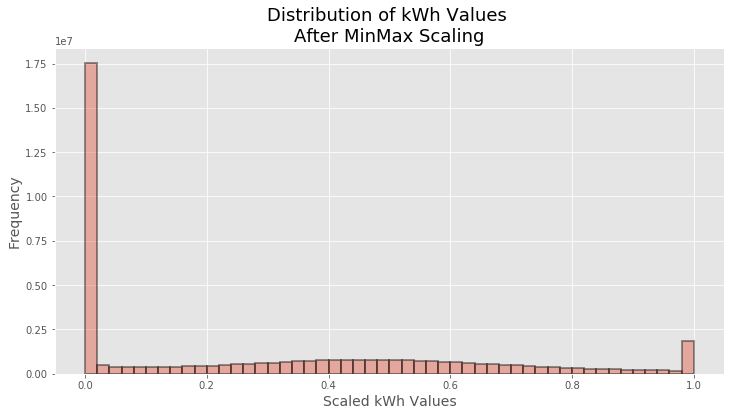

In [12]:
# Confirm distribution
plt.figure(figsize=(12, 6))
distplot(X_minmax.ravel(), kde=False, 
         hist_kws=dict(edgecolor='k', linewidth=2))
plt.xlabel('Scaled kWh Values', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of kWh Values \nAfter MinMax Scaling', fontsize=18);

## `Standard` Scaling

In [0]:
# Instantiate a Standard Scaler
stdScaler = StandardScaler()

In [0]:
# Fit to features on consumer-basis through transpostions
X_standard = stdScaler.fit_transform(X.transpose()).transpose()

In [14]:
# Confirm shape
X_standard.shape

(42372, 1034)

Text(0.5, 1.0, 'Distribution of kWh Values \nAfter Standard Scaling')

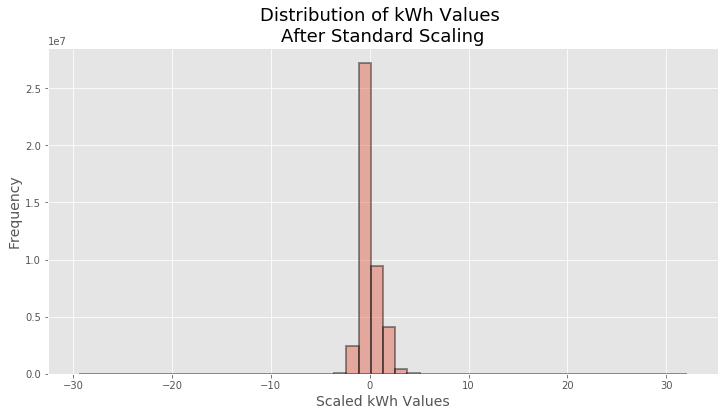

In [15]:
# Confirm distribution
plt.figure(figsize=(12, 6))
distplot(X_standard.ravel(), kde=False, 
         hist_kws=dict(edgecolor='k', linewidth=2))
plt.xlabel('Scaled kWh Values', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of kWh Values \nAfter Standard Scaling', fontsize=18)

# SVC - Zheng 

Zheng's Support Vector Classifier has the following hyperparameters 
- Penalty parameter of the error term: 1.0. In `sklearn`, this is equivalent to the `C` parameter of the `SVC` class.
- kernel: radial basis function (RBF). This is represented in the `SVC` class as `kernel`.


## Version 1 - Standard Scaling

The primary problem with `SVM` is that it takes very long to train. Through experimentation, I have determined that with a training ratio of 80%, training with `StandardScaler`-processed data takes ~16.7 minutes on CoLab with a `GPU` hardware accelerator.

`cross_validate` and `GridSearchCV`, both of which make multiple models and fit them to multiple folds of data (although not as large as the original training data). This means these operations will take very long to run. 

For now, I will simply train and evaluate SVMs using Zheng's hyperparameters separately on data produced by `StandardScaler` and `MinMaxScaler`.

### Train-Test Split 

Training ratio has a more substantial effect on training time than in other algorithms. 

Complexity of SVMs is $\mathcal{O}(n\times m^2)$, where $n$ is the number of features, and $m$ is the number of samples. 

It is clear that the training set size will dominate the computational cost of the SVM algorithm. 

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_standard, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=0, 
                                                    stratify=y)

### Training

- 20% training ratio $\rightarrow$ ~0.97 minutes (recorded)
- 60% training ratio $\rightarrow$ ~10 minutes (recorded)
- 80% training ratio $\rightarrow$ ~16 minutes (expected, recorded time was **43 minutes** (!!))

In [0]:
svc_zheng_std = SVC(C=1.0, kernel='rbf', random_state=0, verbose=True)

In [39]:
# Record start time 
t_start = time.time() 

# Fit the SVC
svc_zheng_std.fit(X_train, y_train)

# Record end time 
t_end = time.time()

# Print time for training
print((t_end - t_start) / 60)

[LibSVM]43.26857993602753


In [0]:
# Saving the model
from joblib import dump, load

In [43]:
# Save the model as joblib file that can be loaded later on
dump(svc_zheng_std, 'svc_zheng_std.joblib')

['svc_zheng_std.joblib']

In [44]:
# How big is this file?
!ls -alt svc_zheng_std.joblib

-rw-r--r-- 1 root root 106221959 Feb 23 10:15 svc_zheng_std.joblib


### Testing 

CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.92      1.00      0.96      7752
           Thief       1.00      0.01      0.02       723

        accuracy                           0.92      8475
       macro avg       0.96      0.50      0.49      8475
    weighted avg       0.92      0.92      0.88      8475

[[9.14690265e-01 0.00000000e+00]
 [8.44837758e-02 8.25958702e-04]]


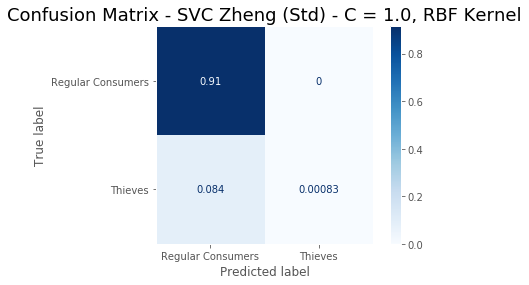

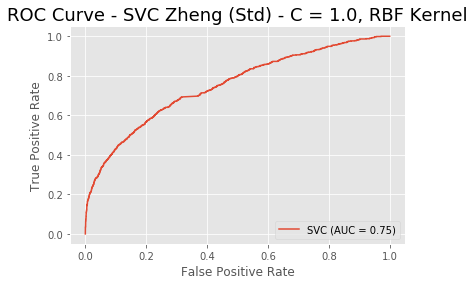

In [45]:
get_classification_result(estimator=svc_zheng_std, 
                          X=X_test, 
                          y_true=y_test, 
                          classifier_name='SVC Zheng (Std) - C = 1.0, RBF Kernel')

# Why is this a bad model?
- It took very long to train.
- It also took very long to make predictions and render a classification matrix. 
- I do not like support vector machines.